In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/internshipProject/lung_cancer/Lung Cancer/dataset_med.csv")

print(df.head())


# Drop unnecessary columns
if 'id' in df.columns:
    df.drop(columns=['id'], inplace=True)

# Separate features and target
X = df.drop(columns=['survived'])
y = df['survived']

# Identify columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessor
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


   id   age  gender      country diagnosis_date cancer_stage family_history  \
0   1  64.0    Male       Sweden     2016-04-05      Stage I            Yes   
1   2  50.0  Female  Netherlands     2023-04-20    Stage III            Yes   
2   3  65.0  Female      Hungary     2023-04-05    Stage III            Yes   
3   4  51.0  Female      Belgium     2016-02-05      Stage I             No   
4   5  37.0    Male   Luxembourg     2023-11-29      Stage I             No   

   smoking_status   bmi  cholesterol_level  hypertension  asthma  cirrhosis  \
0  Passive Smoker  29.4                199             0       0          1   
1  Passive Smoker  41.2                280             1       1          0   
2   Former Smoker  44.0                268             1       1          0   
3  Passive Smoker  43.0                241             1       1          0   
4  Passive Smoker  19.7                178             0       0          0   

   other_cancer treatment_type end_treatment_date 

**About dataset**

In [6]:
# Basic structure
print("Dataset shape:", df.shape)
print("\nData types and non-null counts:")
print(df.info())

# Check for missing values
print("\nMissing Values per Column:")
print(df.isnull().sum())

# Check class distribution
print("\nTarget Variable Distribution (survived):")
print(y.value_counts())
print("\nClass Proportion (%):")
print(y.value_counts(normalize=True) * 100)

# Quick statistical summary
print("\nNumerical Summary:")
print(df.describe())

# Unique values in categorical columns
print("\nUnique values per categorical column:")
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values")

# Correlation check (numerical only)
print("\nTop correlated features with 'survived':")
print(df.corr(numeric_only=True)['survived'].sort_values(ascending=False))


Dataset shape: (890000, 16)

Data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890000 entries, 0 to 889999
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   age                 890000 non-null  float64
 1   gender              890000 non-null  object 
 2   country             890000 non-null  object 
 3   diagnosis_date      890000 non-null  object 
 4   cancer_stage        890000 non-null  object 
 5   family_history      890000 non-null  object 
 6   smoking_status      890000 non-null  object 
 7   bmi                 890000 non-null  float64
 8   cholesterol_level   890000 non-null  int64  
 9   hypertension        890000 non-null  int64  
 10  asthma              890000 non-null  int64  
 11  cirrhosis           890000 non-null  int64  
 12  other_cancer        890000 non-null  int64  
 13  treatment_type      890000 non-null  object 
 14  end_treatment_date  890

In [7]:
import pandas as pd

# Convert dates to datetime
df['diagnosis_date'] = pd.to_datetime(df['diagnosis_date'], errors='coerce')
df['end_treatment_date'] = pd.to_datetime(df['end_treatment_date'], errors='coerce')

# Feature engineering: extract useful info
df['diagnosis_year'] = df['diagnosis_date'].dt.year
df['diagnosis_month'] = df['diagnosis_date'].dt.month
df['treatment_year'] = df['end_treatment_date'].dt.year
df['treatment_month'] = df['end_treatment_date'].dt.month
df['treatment_duration_days'] = (df['end_treatment_date'] - df['diagnosis_date']).dt.days

# Drop the original date columns
df.drop(columns=['diagnosis_date', 'end_treatment_date'], inplace=True)

# Split features and target
X = df.drop(columns=['survived'])
y = df['survived']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)


Categorical columns: ['gender', 'country', 'cancer_stage', 'family_history', 'smoking_status', 'treatment_type']
Numerical columns: ['age', 'bmi', 'cholesterol_level', 'hypertension', 'asthma', 'cirrhosis', 'other_cancer', 'diagnosis_year', 'diagnosis_month', 'treatment_year', 'treatment_month', 'treatment_duration_days']


**LIGHTGBM**

In [18]:
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    class_weight='balanced',
    random_state=42
)

# Create pipeline
lgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lgb_model)
])

# Train
lgb_pipeline.fit(X_train, y_train)

# Predict
y_pred_lgb = lgb_pipeline.predict(X_test)

# Evaluate
print("LightGBM Accuracy:", accuracy_score(y_test, y_pred_lgb))
print(classification_report(y_test, y_pred_lgb))
print(confusion_matrix(y_test, y_pred_lgb))


[LightGBM] [Info] Number of positive: 156803, number of negative: 555197
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 52.208902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16017
[LightGBM] [Info] Number of data points in the train set: 712000, number of used features: 7767
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
LightGBM Accuracy: 0.41098876404494383
              precision    recall  f1-score   support

           0       0.78      0.34      0.47    138799
           1       0.22      0.66      0.33     39201

    accuracy                           0.41    178000
   macro avg       0.50      0.50      0.40    178000
weighted avg       0.66      0.41      0.44    178000

[[47415 91384]
 [13460 25741]]


**LogisticRegression**

In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Logistic Regression Accuracy: 0.7797696629213483
              precision    recall  f1-score   support

           0       0.78      1.00      0.88    138799
           1       0.00      0.00      0.00     39201

    accuracy                           0.78    178000
   macro avg       0.39      0.50      0.44    178000
weighted avg       0.61      0.78      0.68    178000

[[138799      0]
 [ 39201      0]]


**Simple Neural Network**

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Preprocess numerical and categorical separately
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

# Build model
nn_model = Sequential([
    Dense(128, activation='relu', input_dim=X_train_proc.shape[1]),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train
history = nn_model.fit(X_train_proc, y_train, epochs=20, batch_size=1024, validation_split=0.1)

# Predict
y_pred_nn = (nn_model.predict(X_test_proc) > 0.5).astype(int)

# Evaluate
print("Neural Network Accuracy:", accuracy_score(y_test, y_pred_nn))
print(classification_report(y_test, y_pred_nn))
print(confusion_matrix(y_test, y_pred_nn))


Epoch 1/20
626/626 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.7737 - loss: 0.5422 - val_accuracy: 0.7805 - val_loss: 0.5279
Epoch 2/20
626/626 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7787 - loss: 0.5273 - val_accuracy: 0.7805 - val_loss: 0.5285
Epoch 3/20
626/626 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7805 - loss: 0.5192 - val_accuracy: 0.7805 - val_loss: 0.5310
Epoch 4/20
626/626 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7804 - loss: 0.5046 - val_accuracy: 0.7803 - val_loss: 0.5400
Epoch 5/20
626/626 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7862 - loss: 0.4770 - val_accuracy: 0.7749 - val_loss: 0.5576
Epoch 6/20
626/626 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8016 - loss: 0.4412 - val_accuracy: 0.7590 - val_loss: 0.5824
Epoch 7/20
626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8207 - loss: 0.4054 - val_accuracy: 0.7514 - val_loss: 0.6130
Epoch 8/20
626/626 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8396 - loss: 0.3690 - val_accuracy

**XGBoost**

In [8]:
import xgboost as xgb

xgb_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(
        n_estimators=150, learning_rate=0.1, max_depth=4,
        random_state=42, use_label_encoder=False, eval_metric='logloss'
    ))
])

xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


XGBoost Accuracy: 0.7797696629213483
              precision    recall  f1-score   support

           0       0.78      1.00      0.88    138799
           1       0.00      0.00      0.00     39201

    accuracy                           0.78    178000
   macro avg       0.39      0.50      0.44    178000
weighted avg       0.61      0.78      0.68    178000

[[138799      0]
 [ 39201      0]]


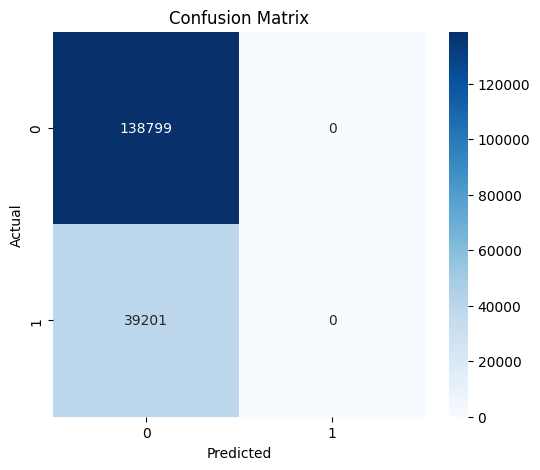

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


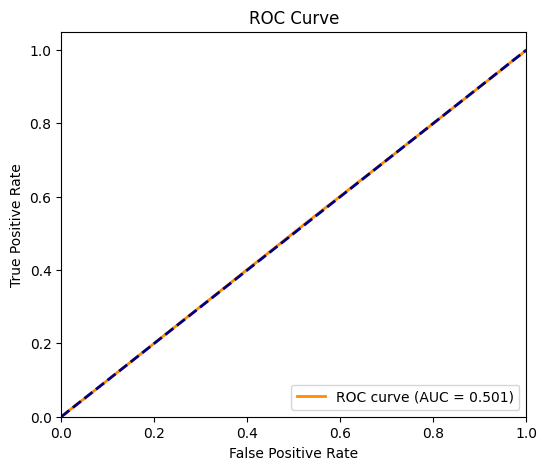

In [11]:
from sklearn.metrics import roc_curve, auc

# Predicted probabilities
y_prob = xgb_clf.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.3f)' % roc_auc)
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


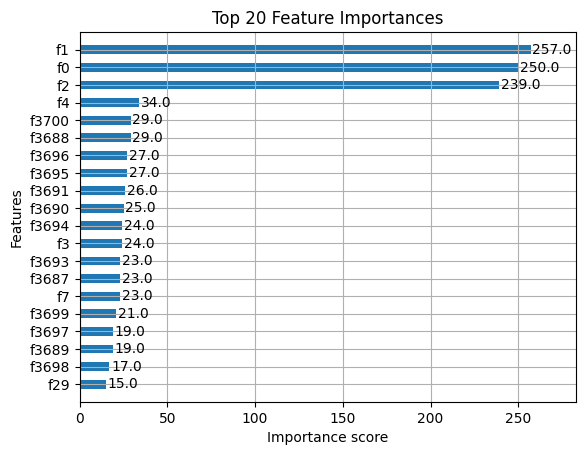

In [17]:
import numpy as np

# Function to get feature names after preprocessing
def get_feature_names(column_transformer):
    feature_names = []

    for name, transformer, columns in column_transformer.transformers_:
        if name == 'num':
            feature_names.extend(columns)
        elif name == 'cat':
            # Get names from one-hot encoder
            ohe = transformer.named_steps['encoder']
            ohe_names = ohe.get_feature_names_out(columns)
            feature_names.extend(ohe_names)
    return feature_names

feature_names = get_feature_names(xgb_clf.named_steps['preprocessor'])
import matplotlib.pyplot as plt
import xgboost as xgb

# Extract trained classifier
xgb_model = xgb_clf.named_steps['classifier']

# Plot top 20 features
xgb.plot_importance(xgb_model, max_num_features=20, height=0.5, importance_type='weight')
plt.title('Top 20 Feature Importances')
plt.show()
